In [2]:
# imports
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
from numpy.fft import fft, ifft , rfft, irfft , fftfreq
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt
import math
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.special import gamma
from scipy.special import hyp2f1
import sys,os
from time import time
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy import special
from scipy.special import factorial

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# fonts and sizes
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [5.8,5.8]

In [3]:
#open four lensing noise files
f2 = open('/Users/juliexue/Desktop/fishchips/notebooks/planck_noise_k.txt')
planck = []

for x in f2.readlines():
    planck.append(x.split()[1])

planck_1 = np.array(planck[1:2080:])
planck_1 = planck_1.astype('float64')

In [4]:
# define function CL; set z_pk
CL = Class()

# set parameter values in fixed and varied sets of Lambda-CDM and IDM
# use fiducial cosmology (Planck-2015) paramaters; see Appendix Table 2
# note: small o for omega refers to REDUCED parameter; omega_b = Omega_b*h^2
fixed_lcdm = {'A_s':2.2e-09,
              'n_s':0.966,
              'tau_reio':0.06,
              'omega_b':0.0222,
              'h':0.69,
              'omega_cdm':0.120,
              'output':'mPk,tCl,pCl,lCl',
              'lensing':'no'}

# when trying to simulate IDM model set omega_dmeff = 0.120 and omega_cdm = 0; for LCDM vice versa
fixed_idm = {'omega_b':0.0222,
             'omega_cdm':0,
             'tau_reio':0.06,
             'h':0.69,
             'A_s':2.2e-09,
             'n_s':0.966,
             'omega_dmeff':0.120,
             'm_dmeff':1.0,
             'npow_dmeff':0,
             'Vrel_dmeff':0,
             'output':'mPk,tCl,pCl,lCl',
             'lensing':'no'}

EFT_off = {'non linear':'no'}

EFT_on = {'non linear':'PT',
             'IR resummation':'Yes',
             'Bias tracers':'Yes',
             'cb':'No',
             'RSD':'Yes',
             'AP':'Yes',
             'Omfid':'0.31'}

# fiducial spectra without EFT
CL.struct_cleanup()
CL.empty()
CL.set(fixed_lcdm)
#CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
fiducial_without_EFT = CL.raw_cl(2500)
l = fiducial_without_EFT['ell'][2:]
fiducial_without_EFT_TT = fiducial_without_EFT['tt'][2:]
fiducial_without_EFT_EE = fiducial_without_EFT['ee'][2:]
fiducial_without_EFT_PP = fiducial_without_EFT['pp'][2:]
fiducial_without_EFT_kk = []
for x, y in zip(l, fiducial_without_EFT_PP):
    fiducial_without_EFT_kk.append(1/4*y*(x-1)*x*(x+1)*(x+2))
CL.struct_cleanup()
CL.empty()

# fiducial spectra with EFT
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
fiducial_with_EFT = CL.raw_cl(2500)
fiducial_with_EFT_TT = fiducial_with_EFT['tt'][2:]
fiducial_with_EFT_EE = fiducial_with_EFT['ee'][2:]
fiducial_with_EFT_PP = fiducial_with_EFT['pp'][2:]
fiducial_with_EFT_kk = []
for x, y in zip(l, fiducial_with_EFT_PP):
    fiducial_with_EFT_kk.append(1/4*y*(x-1)*x*(x+1)*(x+2))
CL.struct_cleanup()
CL.empty()

In [5]:
# compute C_l TT for m_ncdm = 0.07 with and without EFT
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.07,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm1_cls_on = CL.raw_cl(2500)
ncdm1_TT_on = ncdm1_cls_on['tt'][2:]
residual_ncdm1_on = np.subtract(ncdm1_TT_on, fiducial_with_EFT_TT)
residual_percentage_ncdm1_on = 100*np.divide(residual_ncdm1_on, fiducial_with_EFT_TT)

CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.07,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm1_cls_off = CL.raw_cl(2500)
ncdm1_TT_off = ncdm1_cls_off['tt'][2:]
residual_ncdm1_off = np.subtract(ncdm1_TT_off, fiducial_without_EFT_TT)
residual_percentage_ncdm1_off = 100*np.divide(residual_ncdm1_off, fiducial_without_EFT_TT)

# compute C_l EE for m_ncdm = 0.065 with and without EFT
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.065,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm2_cls_on = CL.raw_cl(2500)
ncdm2_EE_on = ncdm2_cls_on['ee'][2:]
residual_ncdm2_on = np.subtract(ncdm2_EE_on, fiducial_with_EFT_EE)
residual_percentage_ncdm2_on = 100*np.divide(residual_ncdm2_on, fiducial_with_EFT_EE)

CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.065,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm2_cls_off = CL.raw_cl(2500)
ncdm2_EE_off = ncdm2_cls_off['ee'][2:]
residual_ncdm2_off = np.subtract(ncdm2_EE_off, fiducial_without_EFT_EE)
residual_percentage_ncdm2_off = 100*np.divide(residual_ncdm2_off, fiducial_without_EFT_EE)

# compute C_l kappa-kappa for m_ncdm = 0.08 with and without EFT
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.08,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm3_cls_on = CL.raw_cl(2500)
ncdm3_PP_on = ncdm3_cls_on['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
ncdm3_kk_on = []
for x, y in zip(l, ncdm3_PP_on):
    ncdm3_kk_on.append(1/4*y*(x-1)*x*(x+1)*(x+2))
residual_ncdm3_on = np.subtract(ncdm3_kk_on, fiducial_with_EFT_kk)
residual_percentage_ncdm3_on = 100*np.divide(residual_ncdm3_on, fiducial_with_EFT_kk)

CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1.0,
       'm_ncdm':0.08,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.compute()
ncdm3_cls_off = CL.raw_cl(2500)
ncdm3_PP_off = ncdm3_cls_off['pp'][2:]
ncdm3_kk_off = []
for x, y in zip(l, ncdm3_PP_off):
    ncdm3_kk_off.append(1/4*y*(x-1)*x*(x+1)*(x+2))
residual_ncdm3_off = np.subtract(ncdm3_kk_off, fiducial_without_EFT_kk)
residual_percentage_ncdm3_off = 100*np.divide(residual_ncdm3_off, fiducial_without_EFT_kk)

In [6]:
# compute C_l TT for N_eff (paper notation) = N_ur = 3.06; EFT on
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.06
       })
CL.compute()
Nur1_cls_on = CL.raw_cl(2500)
Nur1_TT_on = Nur1_cls_on['tt'][2:]
# compute residual for N_ur = 3.096
residual_Nur1_on = np.subtract(Nur1_TT_on, fiducial_with_EFT_TT)
residual_percentage_Nur1_on = 100*np.divide(residual_Nur1_on, fiducial_with_EFT_TT)

# compute C_l TT for N_eff (paper notation) = N_ur = 3.06; EFT off
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.06
       })
CL.compute()
Nur1_cls_off = CL.raw_cl(2500)
Nur1_TT_off = Nur1_cls_off['tt'][2:]
# compute residual for N_ur = 3.096
residual_Nur1_off = np.subtract(Nur1_TT_off, fiducial_without_EFT_TT)
residual_percentage_Nur1_off = 100*np.divide(residual_Nur1_off, fiducial_without_EFT_TT)

# compute C_l EE for N_eff (paper notation) = N_ur = 3.05; EFT on
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.05
       })
CL.compute()
Nur2_cls_on = CL.raw_cl(2500)
Nur2_EE_on = Nur2_cls_on['ee'][2:]
# compute residual for N_ur = 3.096
residual_Nur2_on = np.subtract(Nur2_EE_on, fiducial_with_EFT_EE)
residual_percentage_Nur2_on = 100*np.divide(residual_Nur2_on, fiducial_with_EFT_EE)

# compute C_l EE for N_eff (paper notation) = N_ur = 3.05; EFT off
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.05
       })
CL.compute()
Nur2_cls_off = CL.raw_cl(2500)
Nur2_EE_off = Nur2_cls_off['ee'][2:]
# compute residual for N_ur = 3.096
residual_Nur2_off = np.subtract(Nur2_EE_off, fiducial_without_EFT_EE)
residual_percentage_Nur2_off = 100*np.divide(residual_Nur2_off, fiducial_without_EFT_EE)

In [7]:
# compute C_l for p_ann = annihilation = 1.4e-07
# With the input suntax of class <= 2.9 we used: annihilation = 1.e-5 m^3/s/Kg
# With the new syntax this is equivalent to DM_annihilation_efficiency = 1.11e-22 m^3/s/J
# so compute C_l TT for p_ann = DM_annihilation_efficiency = 1.556e-24; EFT on
# (the ratio is a factor (c/[1 m/s])**2 = 9.e16)
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':1.556e-24,
       'N_ur':3.046
       })
CL.compute()
pann1_cls_on = CL.raw_cl(2500)
pann1_TT_on = pann1_cls_on['tt'][2:]
# compute residual for DM_annihilation_efficiency = 1.556e-24
residual_pann1_on = np.subtract(pann1_TT_on, fiducial_with_EFT_TT)
residual_percentage_pann1_on = 100*np.divide(residual_pann1_on, fiducial_with_EFT_TT)

# so compute C_l TT for p_ann = DM_annihilation_efficiency = 1.556e-24; EFT off
# (the ratio is a factor (c/[1 m/s])**2 = 9.e16)
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':1.556e-24,
       'N_ur':3.046
       })
CL.compute()
pann1_cls_off = CL.raw_cl(2500)
pann1_TT_off = pann1_cls_off['tt'][2:]
# compute residual for DM_annihilation_efficiency = 1.556e-24
residual_pann1_off = np.subtract(pann1_TT_off, fiducial_with_EFT_TT)
residual_percentage_pann1_off = 100*np.divide(residual_pann1_off, fiducial_with_EFT_TT)

# compute C_l EE for p_ann = annihilation = 1.4e-07; EFT on
# so DM_annihilation_efficiency = 1.556e-24
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':1.556e-24,
       'N_ur':3.046
       })
CL.compute()
pann2_cls_on = CL.raw_cl(2500)
pann2_EE_on = pann2_cls_on['ee'][2:]
# compute residual for DM_annihilation_efficiency = 1.556e-24
residual_pann2_on = np.subtract(pann2_EE_on, fiducial_with_EFT_EE)
residual_percentage_pann2_on = 100*np.divide(residual_pann2_on,fiducial_with_EFT_EE)

# compute C_l EE for p_ann = annihilation = 1.4e-07; EFT off
# so DM_annihilation_efficiency = 1.556e-24
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':1.556e-24,
       'N_ur':3.046
       })
CL.compute()
pann2_cls_off = CL.raw_cl(2500)
pann2_EE_off = pann2_cls_off['ee'][2:]
# compute residual for DM_annihilation_efficiency = 1.556e-24
residual_pann2_off = np.subtract(pann2_EE_off, fiducial_with_EFT_EE)
residual_percentage_pann2_off = 100*np.divide(residual_pann2_off,fiducial_with_EFT_EE)

In [8]:
# compute C_l for N_eff (paper notation) = N_ur = 3.096; EFT on
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.096
       })
CL.compute()
Nur3_cls_on = CL.raw_cl(2500)
Nur3_PP_on = Nur3_cls_on['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
Nur3_kk_on = []
for x, y in zip(l, Nur3_PP_on):
    Nur3_kk_on.append(1/4*y*(x-1)*x*(x+1)*(x+2))
# compute residual for N_ur = 3.096
residual_Nur3_on = np.subtract(Nur3_kk_on, fiducial_with_EFT_kk)
residual_percentage_Nur3_on = 100*np.divide(residual_Nur3_on, fiducial_with_EFT_kk)

# compute C_l for N_eff (paper notation) = N_ur = 3.096; EFT off
CL.empty()
CL.set(fixed_lcdm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.096
       })
CL.compute()
Nur3_cls_off = CL.raw_cl(2500)
Nur3_PP_off = Nur3_cls_off['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
Nur3_kk_off = []
for x, y in zip(l, Nur3_PP_off):
    Nur3_kk_off.append(1/4*y*(x-1)*x*(x+1)*(x+2))
# compute residual for N_ur = 3.096
residual_Nur3_off = np.subtract(Nur3_kk_off, fiducial_without_EFT_kk)
residual_percentage_Nur3_off = 100*np.divide(residual_Nur3_off, fiducial_without_EFT_kk)

# compute C_l for sigma_p (paper notation) = sigma_dmeff = 8.8e-27; EFT on
CL.empty()
CL.set(fixed_idm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.set({'sigma_dmeff':8.8e-27})
CL.compute()
dmeff3_cls_on = CL.raw_cl(2500)
dmeff3_PP_on = dmeff3_cls_on['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
dmeff3_kk_on = []
for x, y in zip(l, dmeff3_PP_on):
    dmeff3_kk_on.append(1/4*y*(x-1)*x*(x+1)*(x+2))
# compute residual for sigma_dmeff = 8.8e-27
residual_dmeff3_on = np.subtract(dmeff3_kk_on, fiducial_with_EFT_kk)
residual_percentage_dmeff3_on = 100*np.divide(residual_dmeff3_on,fiducial_with_EFT_kk)

# compute C_l for sigma_p (paper notation) = sigma_dmeff = 8.8e-27; EFT off
CL.empty()
CL.set(fixed_idm)
CL.set(EFT_off)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.set({'sigma_dmeff':8.8e-27})
CL.compute()
dmeff3_cls_off = CL.raw_cl(2500)
dmeff3_PP_off = dmeff3_cls_off['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
dmeff3_kk_off = []
for x, y in zip(l, dmeff3_PP_off):
    dmeff3_kk_off.append(1/4*y*(x-1)*x*(x+1)*(x+2))
# compute residual for sigma_dmeff = 8.8e-27
residual_dmeff3_off = np.subtract(dmeff3_kk_off, fiducial_without_EFT_kk)
residual_percentage_dmeff3_off = 100*np.divide(residual_dmeff3_off,fiducial_without_EFT_kk)

In [33]:
# create an Observables object to store information for derivatives
pars = np.array( ['sigma_dmeff'])
centers = np.array([1e-25])
steps = np.array([1e-25])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-steps,
                  right=centers+steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl',
                   'l_max_scalars': 2500,
                   'lensing': 'yes',
                   'omega_cdm':1e-15,
                   'omega_dmeff':0.120,
                   'npow_dmeff':0,
                   'Vrel_dmeff':0,
                   'dmeff_target': 'baryons',
                   'm_dmeff':1.,
                   'lensing': 'y' }

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# generate the fiducial cosmology
obs.compute_cosmo(key='fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_right', classy_dict=classy_right)

In [37]:
CMB_S4 = CMB_Primary(
    theta_fwhm=[1.5], sigma_T=[1.], sigma_P=[1.],
    f_sky=0.4, l_min=2, l_max=2500)
ACT_or_S3 = CMB_Primary(
    theta_fwhm=[1.4], sigma_T=[10.], sigma_P=[10.],
    f_sky=0.4, l_min=2, l_max=2078)
Planck_assumption = CMB_Primary(
    theta_fwhm=[14,10,7.,5.,5.], sigma_T=[137,65.,43.,66.,200], sigma_P=[450,103.,81.,134.,406],
    f_sky=0.6, l_min=2, l_max=2078)

fisher_TT = CMB_S4.get_fisher_per_l_TT(obs)[:2499]
TT_error_bar = (1/fisher_TT)**(1/2)
TT_error_bar_percentage = 100*TT_error_bar/fiducial_with_EFT_TT
TT_error_bar_percentage

/Users/juliexue/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


array([           inf,            inf, 5.14368016e-07, ...,
       1.70591000e-06, 1.70743270e-06, 1.70900064e-06])

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 216, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


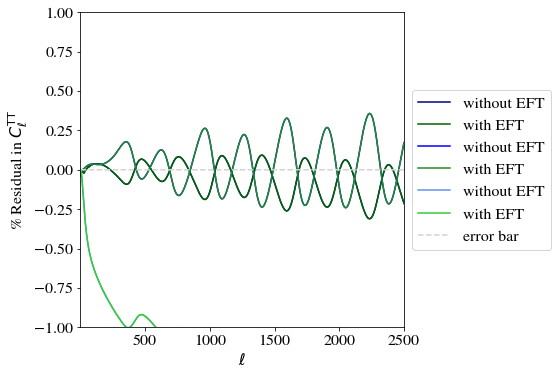

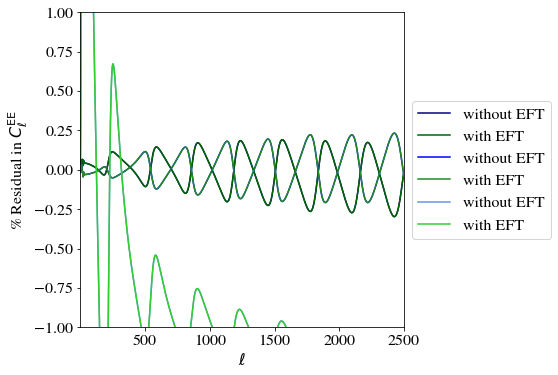

In [38]:
# test plots

plt.figure(1)
plt.xlim([1,2500])
plt.ylim([-1,1])
# plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.plot(l, residual_percentage_ncdm1_off, color = 'navy', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_ncdm1_on, color = 'darkgreen', linestyle = '-', label = 'with EFT')
plt.plot(l, residual_percentage_Nur1_off, color = 'blue', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_Nur1_on, color = 'forestgreen', linestyle = '-', label = 'with EFT')
plt.plot(l, residual_percentage_pann1_off, color = 'cornflowerblue', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_pann1_on, color = 'limegreen', linestyle = '-', label = 'with EFT')
plt.plot(l, TT_error_bar_percentage, color=r'#D3D3D3', ls='--', label = 'error bar')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(2)
plt.xlim([1,2500])
plt.ylim([-1,1])
# plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{EE}$')
plt.plot(l, residual_percentage_ncdm2_off, color = 'navy', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_ncdm2_on, color = 'darkgreen', linestyle = '-', label = 'with EFT')
plt.plot(l, residual_percentage_Nur2_off, color = 'blue', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_Nur2_on, color = 'forestgreen', linestyle = '-', label = 'with EFT')
plt.plot(l, residual_percentage_pann2_off, color = 'cornflowerblue', linestyle = '-', label = 'without EFT')
plt.plot(l, residual_percentage_pann2_on, color = 'limegreen', linestyle = '-', label = 'with EFT')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

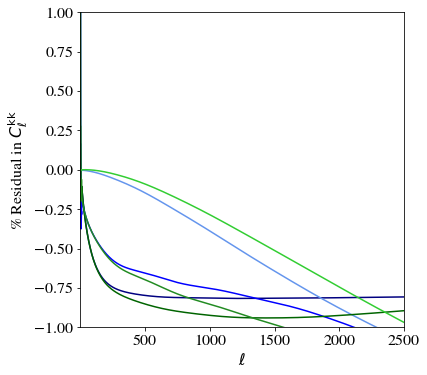

In [42]:
# kappa-kappa residuals with EFT on and off
l_kk = l[:2079]
fid_kk = fiducial_with_EFT_kk[:2079]



plt.figure(1)
plt.xlim([1,2500])
plt.ylim([-1,1])
# plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{kk}$')
plt.plot(l, residual_percentage_ncdm3_off, color = 'navy', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$ without EFT')
plt.plot(l, residual_percentage_Nur3_off, color = 'blue', linestyle = '-', label = r'$N_\mathrm{eff}$ without EFT')
plt.plot(l, residual_percentage_dmeff3_off, color = 'cornflowerblue', linestyle = '-', label = r'$\sigma_\mathrm{p}$ without EFT')
plt.plot(l, residual_percentage_ncdm3_on, color = 'darkgreen', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$ with EFT')
plt.plot(l, residual_percentage_Nur3_on, color = 'forestgreen', linestyle = '-', label = r'$N_\mathrm{eff}$ with EFT')
plt.plot(l, residual_percentage_dmeff3_on, color = 'limegreen', linestyle = '-', label = r'$\sigma_\mathrm{p}$ with EFT')
plt.legend()

plt.figure(2)
plt.xlim([1,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{kk}$')
plt.plot(l, residual_percentage_ncdm3_on, color = 'darkgreen', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$ with EFT')
plt.plot(l, residual_percentage_Nur3_on, color = 'forestgreen', linestyle = '-', label = r'$N_\mathrm{eff}$ with EFT')
plt.plot(l, residual_percentage_dmeff3_on, color = 'limegreen', linestyle = '-', label = r'$\sigma_\mathrm{p}$ with EFT')
plt.legend()

In [44]:
# compute C_l for sigma_p (paper notation) = sigma_dmeff = 2.1e-26
CL.empty()
CL.set(fixed_idm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.set({'sigma_dmeff':2.1e-26})
CL.compute()
dmeff1_cls = CL.raw_cl(2500)
dmeff1_ll = dmeff1_cls['ell'][2:]
dmeff1_TT = dmeff1_cls['tt'][2:]
# compute residual for sigma_dmeff = 2.1e-26
residual_dmeff1 = np.subtract(dmeff1_TT, fiducial_with_EFT_TT)
residual_percentage_dmeff1 = 100*np.divide(residual_dmeff1,fiducial_with_EFT_TT)

# compute C_l for sigma_p (paper notation) = sigma_dmeff = 2.0e-26
CL.empty()
CL.set(fixed_idm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.set({'sigma_dmeff':2.0e-26})
CL.compute()
dmeff2_cls = CL.raw_cl(2500)
dmeff2_ll = dmeff2_cls['ell'][2:]
dmeff2_EE = dmeff2_cls['ee'][2:]
# compute residual for sigma_dmeff = 2.0e-26
residual_dmeff2 = np.subtract(dmeff2_EE, fiducial_with_EFT_EE)
residual_percentage_dmeff2 = 100*np.divide(residual_dmeff2,fiducial_with_EFT_EE)

# compute C_l for sigma_p (paper notation) = sigma_dmeff = 8.8e-27
CL.empty()
CL.set(fixed_idm)
CL.set(EFT_on)
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })
CL.set({'sigma_dmeff':8.8e-27})
CL.compute()
dmeff3_cls = CL.raw_cl(2500)
dmeff3_ll = dmeff3_cls['ell'][2:]
dmeff3_PP = dmeff3_cls['pp'][2:]
# use for loop and zip to compute kappa-kappa C_ls
dmeff3_kk = []
for x, y in zip(dmeff3_ll, dmeff3_PP):
    dmeff3_kk.append(1/4*y*(x-1)*x*(x+1)*(x+2))
# compute residual for sigma_dmeff = 8.8e-27
residual_dmeff3 = np.subtract(dmeff3_kk, fiducial_with_EFT_kk)
residual_percentage_dmeff3 = 100*np.divide(residual_dmeff3,fiducial_with_EFT_kk)

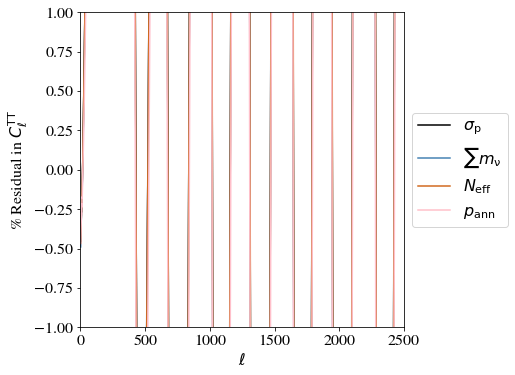

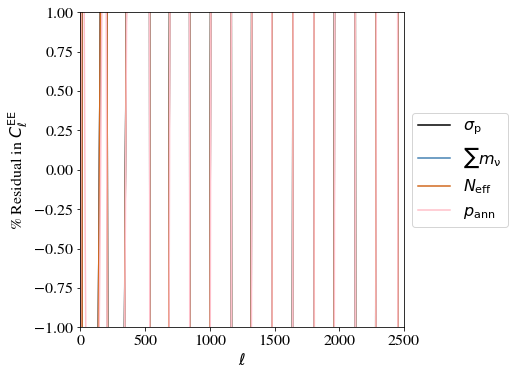

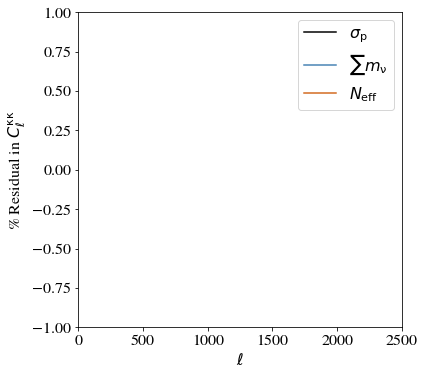

In [46]:
# plot C_l_TT
plt.figure(1)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.plot(dmeff1_ll, residual_percentage_dmeff1, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm1_ll, residual_percentage_ncdm1, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur1_ll, residual_percentage_Nur1, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.plot(pann1_ll, residual_percentage_pann1, color = 'pink', linestyle = '-', label = r'$p_\mathrm{ann}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Clkk.png')

# plot C_l_EE
plt.figure(2)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{EE}$')
plt.plot(dmeff2_ll, residual_percentage_dmeff2, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm2_ll, residual_percentage_ncdm2, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur2_ll, residual_percentage_Nur2, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.plot(pann2_ll, residual_percentage_pann2, color = 'pink', linestyle = '-', label = r'$p_\mathrm{ann}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('Clkk.png')

# plot C_l_kk
plt.figure(3)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{\kappa\kappa}$')
plt.plot(dmeff3_ll, residual_percentage_dmeff3, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm3_ll, residual_percentage_ncdm3, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur3_ll, residual_percentage_Nur3, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.legend()
#plt.savefig('Clkk.png')

In [ ]:

M.compute()

#Extracting and plotting spectra

bg_linear = M.get_background()
th_linear = M.get_thermodynamics()
cl_linear = M.lensed_cl()

bg_EFT = M2.get_background()
th_EFT = M2.get_thermodynamics()
cl_EFT = M2.lensed_cl()

h = M.h()
k = np.linspace(log(0.0001),log(50),200)
k = np.exp(k)
twopi = 2.*math.pi
khvec = k*h

f,ax_list = plt.subplots(1,3,figsize=(9,3),constrained_layout=True)
ax = ax_list.ravel()

ax[0].set_xlabel('$\ell$')
ax[0].set_ylabel('$C_\ell^{TT}-C_\ell^{TT, linear}/C_\ell^{TT, linear}$')
ax[0].set_xlim([1,2500])

ax[1].set_xlabel('$\ell$')
ax[1].set_ylabel('$C_\ell^{EE}-C_\ell^{EE, linear}/C_\ell^{EE, linear}$')
ax[1].set_xlim([1,2500])

#ax[2].set_xscale('log')
ax[2].set_xlabel('$\ell$')
#ax[2].set_yscale('log')
ax[2].set_ylabel('$C_\ell^{\phi\phi}-C_\ell^{\phi\phi, linear}/C_\ell^{\phi\phi, linear}$')
#ax[2].set_xlim([1e-3,1])
#ax[2].set_ylim([-75, 10])

ax[3].set_xscale('log')
ax[3].set_xlabel('$k$')
#ax[3].set_yscale('log')
ax[3].set_ylabel('$(P-P^{linear})/P^{linear}$')
ax[3].set_xlim([1e-3,1])

In [2]:
CL.set(fiducial_settings)
# set parameters to be varied
CL.set({'N_ncdm':1,
       'm_ncdm':0.06,
       'DM_annihilation_efficiency':0,
       'N_ur':3.046
       })

dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

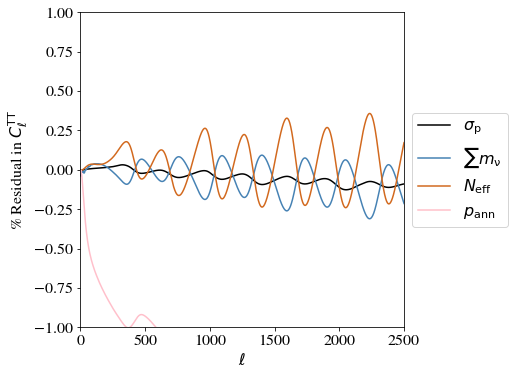

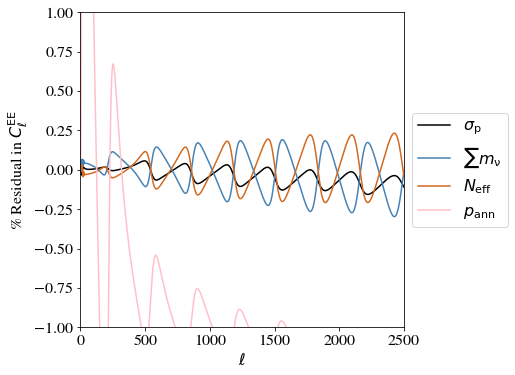

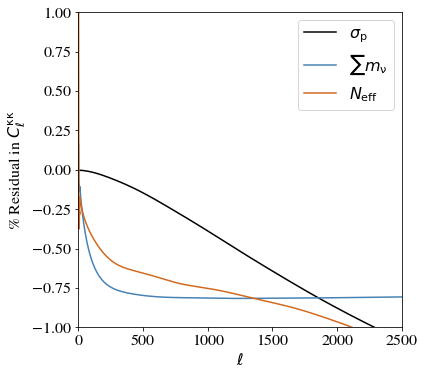

In [42]:
# plot C_l_TT
plt.figure(1)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{TT}$')
plt.plot(dmeff1_ll, residual_percentage_dmeff1, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm1_ll, residual_percentage_ncdm1, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur1_ll, residual_percentage_Nur1, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.plot(pann1_ll, residual_percentage_pann1, color = 'pink', linestyle = '-', label = r'$p_\mathrm{ann}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Cltt.png')

# plot C_l_EE
plt.figure(2)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{EE}$')
plt.plot(dmeff2_ll, residual_percentage_dmeff2, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm2_ll, residual_percentage_ncdm2, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur2_ll, residual_percentage_Nur2, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.plot(pann2_ll, residual_percentage_pann2, color = 'pink', linestyle = '-', label = r'$p_\mathrm{ann}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Clee.png')

# plot C_l_kk
plt.figure(3)
plt.xlim([0,2500])
plt.ylim([-1,1])
plt.xlabel(r'$\ell$')
plt.ylabel(r'% Residual in $C_\ell^\mathrm{\kappa\kappa}$')
plt.plot(dmeff3_ll, residual_percentage_dmeff3, color = 'black', linestyle = '-', label = r'$\sigma_\mathrm{p}$')
plt.plot(ncdm3_ll, residual_percentage_ncdm3, color = 'steelblue', linestyle = '-', label = r'$\sum m_\mathrm{\nu}$')
plt.plot(Nur3_ll, residual_percentage_Nur3, color = 'chocolate', linestyle = '-', label = r'$N_\mathrm{eff}$')
plt.legend()
plt.savefig('Clkk.png')

In [ ]:
power_spectrum_linear = np.linspace(log(0.0001),log(50),200)
power_spectrum_Halofit = np.linspace(log(0.0001),log(50),200)

for i in range(len(k)):
    power_spectrum_linear[i] = M.pk_lin(k[i]*h,z_pk)*h**3
    power_spectrum_Halofit[i] = M1.pk_lin(k[i]*h,z_pk)*h**3

l = np.array(cl_linear['ell'])
l = np.delete(l, 0)
l = np.delete(l, 0)

tt_linear = np.array(cl_linear['tt'])
tt_linear = np.delete(tt_linear, 0)
tt_linear = np.delete(tt_linear, 0)

ee_linear = np.array(cl_linear['ee'])
ee_linear = np.delete(ee_linear, 0)
ee_linear = np.delete(ee_linear, 0)

pp_linear = np.array(cl_linear['pp'])
pp_linear = np.delete(pp_linear, 0)
pp_linear = np.delete(pp_linear, 0)

tt_Halofit = np.array(cl_Halofit['tt'])
tt_Halofit = np.delete(tt_Halofit, 0)
tt_Halofit = np.delete(tt_Halofit, 0)

ee_Halofit = np.array(cl_Halofit['ee'])
ee_Halofit = np.delete(ee_Halofit, 0)
ee_Halofit = np.delete(ee_Halofit, 0)

pp_Halofit = np.array(cl_Halofit['pp'])
pp_Halofit = np.delete(pp_Halofit, 0)
pp_Halofit = np.delete(pp_Halofit, 0)

tt_dmeff_EFT = np.array(cl_EFT['tt'])
tt_dmeff_EFT = np.delete(tt_dmeff_EFT, 0)
tt_dmeff_EFT = np.delete(tt_dmeff_EFT, 0)

ee_dmeff_EFT = np.array(cl_EFT['ee'])
ee_dmeff_EFT = np.delete(ee_dmeff_EFT, 0)
ee_dmeff_EFT = np.delete(ee_dmeff_EFT, 0)

pp_dmeff_EFT = np.array(cl_EFT['pp'])
pp_dmeff_EFT = np.delete(pp_dmeff_EFT, 0)
pp_dmeff_EFT = np.delete(pp_dmeff_EFT, 0)

##Initializing convenience functions pk_mm_real, pk_gg_l0 etc.

M2.initialize_output(khvec, z_pk, len(khvec))

power_spectrum_dmeff_EFT = M2.pk_mm_real(1.)

testout = [[0 for x in range(42)] for y in range(len(k))]

for i in range(len(k)):
    testout[i][0] = k[i]
    testout[i][41] = M2.pk_lin(k[i]*h,z_pk)*h
    for j in range(40):
        testout[i][j+1] = M2.pk(k[i]*h,z_pk)[j]*h

#for i in range(len(k)):
#    for j in range(40):
 #       print(testout[i][j])

#Plotting spectra

ax[0].plot(l, (tt_Halofit-tt_linear)/tt_linear * 100, color = 'green', label=r'$halofit$')
ax[0].plot(l, (tt_dmeff_EFT-tt_linear)/tt_linear * 100, color = 'purple', label=r'$EFT$')
ax[0].legend(fontsize='8',ncol=1,loc='upper right')

ax[1].plot(l, (ee_Halofit-ee_linear)/ee_linear * 100, color = 'green', label=r'$halofit$')
ax[1].plot(l, (ee_dmeff_EFT-ee_linear)/ee_linear * 100, color = 'purple', label=r'$EFT$')
ax[1].legend(fontsize='8',ncol=1,loc='upper right')

ax[2].plot(l, (pp_Halofit-pp_linear)/pp_linear * 100, color = 'green', label=r'$halofit$')
ax[2].plot(l, (pp_dmeff_EFT-pp_linear)/pp_linear * 100, color = 'purple', label=r'$EFT$')
ax[2].legend(fontsize='8',ncol=1,loc='upper right')

ax[3].plot(k, (power_spectrum_Halofit-power_spectrum_linear)/power_spectrum_linear * 100, color = 'green', label=r'$halofit$')
ax[3].plot(k, (power_spectrum_dmeff_EFT-power_spectrum_linear)/power_spectrum_LCDM * 100, color = 'purple', label=r'$EFT$')
ax[3].legend(fontsize='8',ncol=1,loc='upper right')

plot = ax[0].get_figure()
plot.show()

#Cleaning up

M.struct_cleanup()
M.empty()
M1.struct_cleanup()
M1.empty()
M2.struct_cleanup()
M2.empty()